**Instalação e importação de pacotes**

In [ ]:
!pip install -U spacy

In [ ]:
!pip install unidecode

In [ ]:
!pip install skimpy

In [ ]:
!python -m spacy download pt_core_news_lg

In [ ]:
import spacy
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
from unidecode import unidecode
import re
from string import punctuation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report 
from math import pi
from skimpy import skim

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Mounted at /content/drive


**Definição de tratamentos para pré-processamento dos dados**

In [ ]:
# Carrega o modelo spacy em Portugês
pln = spacy.load('pt_core_news_lg')

In [ ]:
# Definição de stopwords
with open('drive/MyDrive/TCC/stop_words.txt') as arq:
    stop = arq.readlines()
stop = [x.rstrip('\n') for x in stop] 

In [ ]:
# Definição de expressoes sexualizadas
with open('drive/MyDrive/TCC/expressoes_sexualizadas.txt') as arq:
    termo = arq.readlines()
expressoes_sexualizadas = [x.rstrip('\n') for x in termo] 

In [ ]:
# Definição de palavras sexualizadas
with open('drive/MyDrive/TCC/palavras_sexualizadas.txt') as arq:
    termo = arq.readlines()
palavras_sexualizadas = [x.rstrip('\n') for x in termo] 

In [ ]:
#Função para pre processamento da base de dados (Limpeza, remoção de stopwords e tokenização dos dados)
def preprocessamentosemreplace(texto):
  
  # Atribui o pacote de pontuações a uma variável
  pontuacoes = string.punctuation
  # Converte em minúsculo
  texto = texto.lower()
  # Remove acentuação
  texto = unidecode(texto)
  # Remove pontuação
  texto = ''.join(x for x in texto if x not in punctuation)
  # Remove números
  texto = ''.join(x for x in texto if not x.isdigit())
  # Remove tags
  texto = re.sub('<[^<]+?>','', texto)

  # Atribui pacote de tratamento de PLN ao texto de entrada a uma variável
  documento = pln(texto)

  # Gera uma lista vazia
  lista = []

  # Quebra o texto de origem em tokens(palavras)
  for token in documento:
    lista.append(token.text)

  #  A lista recebe os tokens que não são stopwords ou espaço em branco
  lista = [palavra for palavra in lista if palavra not in stop and not palavra.isspace()]

  # Converte a lista em uma string
  texto_tratado = ' '.join([str(elemento) for elemento in lista])

  # Retorna o texto tratado
  return texto_tratado


In [ ]:
#Função para pre processamento da base de dados (Limpeza, remoção de stopwords e tokenização dos dados)
def preprocessamento(texto):
  
  # Atribui o pacote de pontuações a uma variável
  pontuacoes = string.punctuation
  # Converte em minúsculo
  texto = texto.lower()
  # Remove acentuação
  texto = unidecode(texto)
  # Remove pontuação
  texto = ''.join(x for x in texto if x not in punctuation)
  # Remove números
  texto = ''.join(x for x in texto if not x.isdigit())
  # Remove tags
  texto = re.sub('<[^<]+?>','', texto)

  # Substitui expressoes sexualizadas
  for expressoes in expressoes_sexualizadas:
    texto = texto.replace(expressoes,"sexual")

  # Atribui pacote de tratamento de PLN ao texto de entrada a uma variável
  documento = pln(texto)

  # Gera uma lista vazia
  lista = []

  # Quebra o texto de origem em tokens(palavras)
  for token in documento:
    lista.append(token.text)

  #  A lista recebe os tokens que não são stopwords ou espaço em branco
  lista = [palavra for palavra in lista if palavra not in stop and not palavra.isspace()]
  
  # Substitui palavras sexualizadas
  for index, palavra in enumerate(lista):
    if palavra in palavras_sexualizadas:
      lista[index] = "sexual"

  # Converte a lista em uma string
  texto_tratado = ' '.join([str(elemento) for elemento in lista])

  # Retorna o texto tratado
  return texto_tratado


In [ ]:
teste = preprocessamento('Maria foi na rua comprar 1 açucar para sua mãe fazer pudim-.., mas na verdade foi fazer amor, vamos fazer amor,vem me mamar')
teste

'maria rua comprar acucar sua mae fazer pudim mas verdade sexual vamos sexualvem me sexual'

In [ ]:
# Função para converter o dataset para binário
def convertebin(data, arquivo):
    db = spacy.tokens.DocBin()
    docs = []
    for doc, label in pln.pipe(data, as_tuples=True):
        doc.cats["SEX"] = label == "sexualizada"
        doc.cats["NEU"] = label == "neutra"
        db.add(doc)
    
    db.to_disk(arquivo)

**Importação e pré processamento da base de dados de treinamento**



In [ ]:
# Importação da base e verificação do tamanho
base_treinamento = pd.read_csv('drive/MyDrive/TCC/base_treinamento.csv', encoding = 'utf-8')
base_treinamento.shape


(387, 4)

In [ ]:
# Visualização dos primeiros registros da base
base_treinamento.head()

,musica,interprete,classificacao,letra
0,50 por Cento,Naiara Azevedo,sexualizada,Ninguém merece desprezo Meio amor meio beijo N...
1,A Caminho do Bega,DJ Patrick Muniz,sexualizada,DJ Patrick Muniz O mestre do mandelão A caminh...
2,A Cera,O Surto,neutra,Eu 'tava ali Ela também ela também estava ali ...
3,A Dança Do Bumbum,É O Tchan,sexualizada,… Cheguei hein! Estou no paraíso Que abundânci...
4,A Estrada,Cidade Negra,neutra,Uh uh uh Você não sabe o quanto eu caminhei Pr...


[Text(0, 0, '197'), Text(0, 0, '190')]

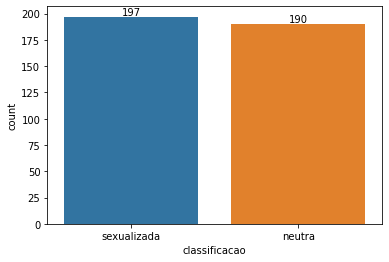

In [ ]:
# Verificação gráfica da quantidade de registros por classe (sexualizada ou neutra)
qtd = base_treinamento['classificacao'].value_counts().rename_axis('classificacao').reset_index(name='count')
graf = sns.barplot(x='classificacao', y='count', data=qtd)
graf.bar_label(graf.containers[0])

In [ ]:
# Aplica a função de pré processamento no campo letra
base_treinamento_original = base_treinamento['letra'].apply(preprocessamentosemreplace)

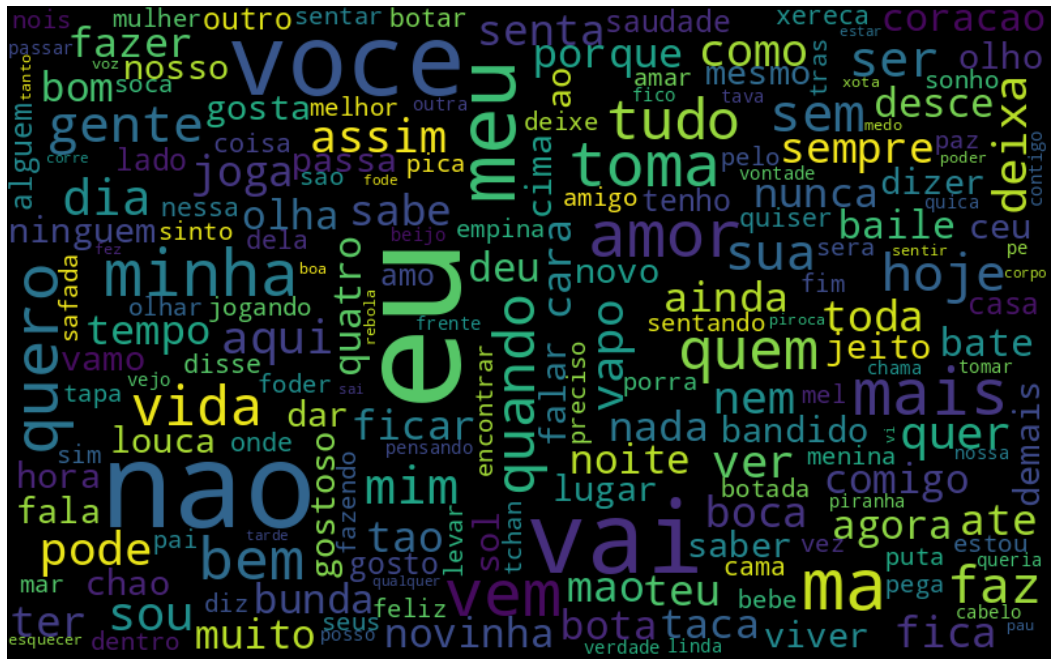

In [ ]:
# Gerar nuvem de palavras
palavras = ' '.join([texto for texto in base_treinamento_original])
nuvem_palvras = WordCloud(width= 800, height= 500, max_font_size = 110,collocations = False).generate(palavras)
plt.figure(figsize=(24,12))
plt.imshow(nuvem_palvras, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Aplica a função de pré processamento no campo letra
base_treinamento['letra'] = base_treinamento['letra'].apply(preprocessamento)

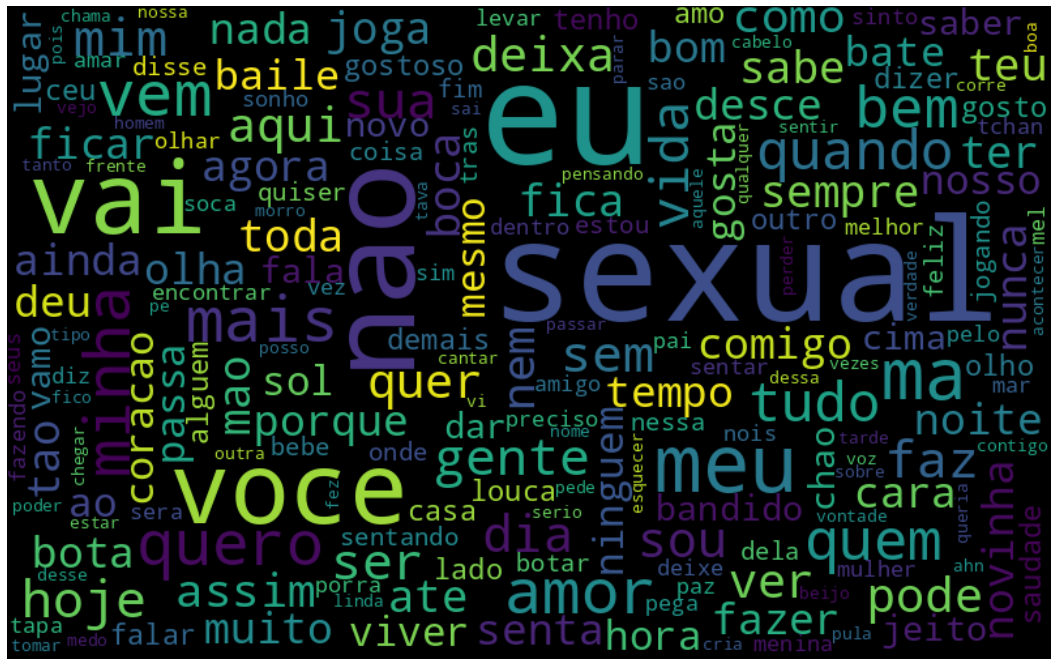

In [ ]:
# Gerar nuvem de palavras
palavras = ' '.join([texto for texto in base_treinamento['letra']])
nuvem_palvras = WordCloud(width= 800, height= 500, max_font_size = 110,collocations = False).generate(palavras)
plt.figure(figsize=(24,12))
plt.imshow(nuvem_palvras, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Gera arquivo 
base_treinamento.to_csv('drive/MyDrive/TCC/base_treinamento_tratada.csv', sep=',', index = False, encoding='utf-8')

In [ ]:
# Divisão do dataset de treinamento em base de treino e desenvolvimento
base_teste_tratada = list(base_treinamento[["letra", "classificacao"]].sample(frac=1).itertuples(index=False, name=None))
base_train = base_teste_tratada[:300]
base_dev = base_teste_tratada[300:362]
print(f"Total: {len(base_teste_tratada)} - Train:  {len(base_train)} - Dev: {len(base_dev)}")

Total: 387 - Train:  300 - Dev: 62


In [ ]:
# Conversão do dataset de treinamento e desenvolvimento para binário
convertebin(base_train, "drive/MyDrive/TCC/train.spacy") 
convertebin(base_dev, "drive/MyDrive/TCC/dev.spacy") 

**Importação e pré processamento da base de dados de teste**


In [ ]:
# Importação da base e verificação do tamanho
base_ecad = pd.read_csv('drive/MyDrive/TCC/base_ecad.csv', encoding = 'utf-8')
base_ecad.shape

(362, 5)

[Text(0, 0, '285'), Text(0, 0, '77')]

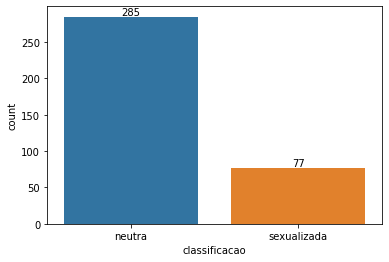

In [ ]:
# Verificação gráfica da quantidade de registros por classe (sexualizada ou neutra)
qtd = base_ecad['classificacao'].value_counts().rename_axis('classificacao').reset_index(name='count')
graf = sns.barplot(x='classificacao', y='count', data=qtd)
graf.bar_label(graf.containers[0])

In [ ]:
# Aplica a função de pré processamento no campo letra
base_ecad_original = base_ecad['letra'].apply(preprocessamentosemreplace)

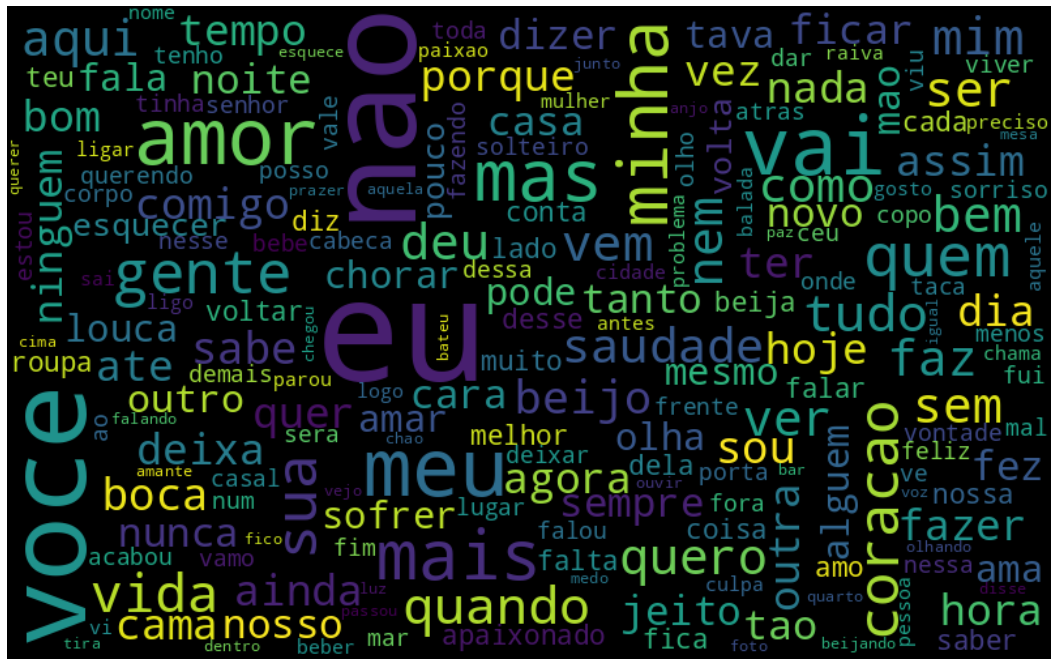

In [ ]:
# Gerar nuvem de palavras
palavras_ecad = ' '.join([texto for texto in base_ecad_original])
nuvem_palvras = WordCloud(width= 800, height= 500, max_font_size = 110,collocations = False).generate(palavras_ecad)
plt.figure(figsize=(24,12))
plt.imshow(nuvem_palvras, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Aplica a função de pré processamento no campo letra
base_ecad['letra'] = base_ecad['letra'].apply(preprocessamento)
# Visualização dos primeiros registros da base
base_ecad.head()

,musica,compositores,idioma,classificacao,letra
0,Se joga no passinho,Juninho Kassanikeo/Deco Teclas,PT,neutra,vem prazer ter voce aqui deixa comigo brisa st...
1,Aí eu ligo,Arthur Castro/Matheus Mattos/Paulinha Gonçalve...,PT,neutra,deu novo sextou aonde vai dar dia chopp dobro ...
2,Raridade,Anderson Freire,PT,neutra,nao consigo alem teu olhar tudo eu consigo ima...
3,Viva voz,Chaianne/Lucas Souza/Murilo Costa/Junior Sillva,PT,sexualizada,deve muito bom voce me ligar hora sua foto nao...
4,Acertou a mao,Bruno Caliman/Raffa Torres,PT,neutra,alguem quiser sorriso pagar milhao vende nao a...


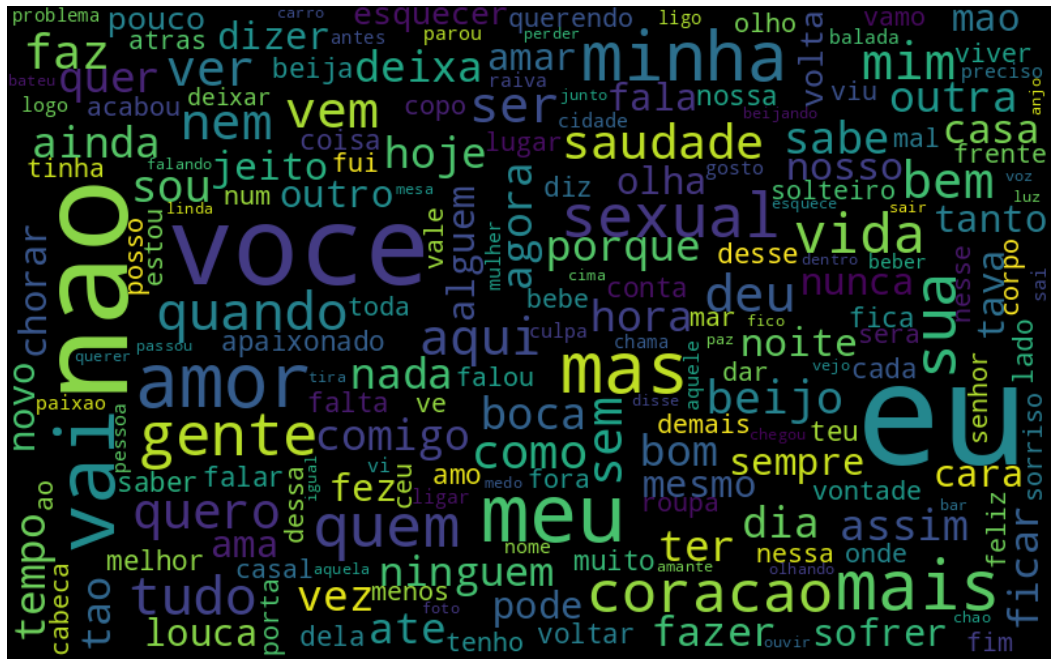

In [ ]:
# Gerar nuvem de palavras
palavras_ecad = ' '.join([texto for texto in base_ecad['letra']])
nuvem_palvras = WordCloud(width= 800, height= 500, max_font_size = 110,collocations = False).generate(palavras_ecad)
plt.figure(figsize=(24,12))
plt.imshow(nuvem_palvras, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Gera arquivo 
base_ecad.to_csv('drive/MyDrive/TCC/base_ecad_tratada.csv', sep=',', index = False, encoding='utf-8')

In [ ]:
# Conversão do dataset de treinamento para binário
base_teste_tratada = list(base_ecad[["letra", "classificacao"]].sample(frac=1).itertuples(index=False, name=None))
convertebin(base_teste_tratada, "drive/MyDrive/TCC/test.spacy") 

**Aplicação do modelo de classificação**

>**Avaliação do modelo**

In [ ]:
# Avaliação do modelo na base ecad
!python -m spacy evaluate drive/MyDrive/TCC/model/model-best/ drive/MyDrive/TCC/test.spacy

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-24 16:23:54.075353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-24 16:23:54.075501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-24 16:23:54.075526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [ ]:
# Teste de avaliação do modelo
texts = ["vamos ao shopping hoje", "quero ver você pelada na minha cama","vamos fazer amor","quero ir passear com você no parque"]
modelo_pln = spacy.load("drive/MyDrive/TCC/model/model-best")
for text in texts:
    doc = modelo_pln(preprocessamento(text))
    print(doc.cats,  "-",  text)

{'SEX': 0.0002957858960144222, 'NEU': 0.9997041821479797} - vamos ao shopping hoje
{'SEX': 1.0, 'NEU': 5.042699591228939e-10} - quero ver você pelada na minha cama
{'SEX': 1.0, 'NEU': 3.1387754808459567e-12} - vamos fazer amor
{'SEX': 0.001047522877342999, 'NEU': 0.9989525079727173} - quero ir passear com você no parque


In [ ]:
base_ecad.head()

,musica,compositores,idioma,classificacao,letra
0,Se joga no passinho,Juninho Kassanikeo/Deco Teclas,PT,neutra,vem prazer ter voce aqui deixa comigo brisa st...
1,Aí eu ligo,Arthur Castro/Matheus Mattos/Paulinha Gonçalve...,PT,neutra,deu novo sextou aonde vai dar dia chopp dobro ...
2,Raridade,Anderson Freire,PT,neutra,nao consigo alem teu olhar tudo eu consigo ima...
3,Viva voz,Chaianne/Lucas Souza/Murilo Costa/Junior Sillva,PT,sexualizada,deve muito bom voce me ligar hora sua foto nao...
4,Acertou a mao,Bruno Caliman/Raffa Torres,PT,neutra,alguem quiser sorriso pagar milhao vende nao a...


In [ ]:
# Aplica o mondelo na base do ecad para recuperar a classificação prevista de cada música
modelo_pln = spacy.load("drive/MyDrive/TCC/model/model-best")
for index, texto in base_ecad.iterrows():
    doc = modelo_pln(texto["letra"])
    #print(doc.cats,  "-",  texto)
    prev_sexualizada = format(doc.cats['SEX'], '.5f')
    prev_neutra = format(doc.cats['NEU'], '.5f')
    base_ecad.loc[index,"previsao_sexualizada"] = prev_sexualizada
    base_ecad.loc[index,"previsao_neutra"] = prev_neutra
    if prev_sexualizada >= prev_neutra:
      base_ecad.loc[index,"previsao"] = "sexualizada"
    else:
      base_ecad.loc[index,"previsao"] = "neutra" 

In [ ]:
# Métrica de acurácia referente a aplicação do modelo na base de ecad
accuracy_score(base_ecad['classificacao'].values, base_ecad['previsao'].values)

0.8397790055248618

<Axes: >

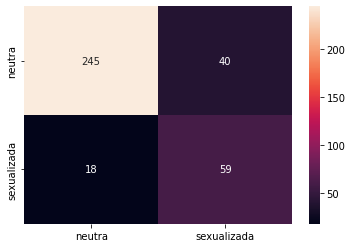

In [ ]:
# Matriz de confusão referente a aplicação do modelo na base de ecad
cm_ecad = confusion_matrix(base_ecad['classificacao'].values, base_ecad['previsao'].values)
sns.heatmap(cm_ecad, annot=True, fmt='.3g', xticklabels = ["neutra","sexualizada"], yticklabels = ["neutra","sexualizada"])

In [ ]:
# Relatório de métricas referente a aplicação do modelo na base ecad
print(classification_report(base_ecad['classificacao'].values, base_ecad['previsao'].values))

              precision    recall  f1-score   support

      neutra       0.93      0.86      0.89       285
 sexualizada       0.60      0.77      0.67        77

    accuracy                           0.84       362
   macro avg       0.76      0.81      0.78       362
weighted avg       0.86      0.84      0.85       362




**Tratamentos para gerar a base de dados final**

In [ ]:
# O ranking do ECAD é publicado nos meses de janeiro, abril, julho e outubro e correpondem ao trimestre de dois trimestre anteriores. 

# Função para converter mês para trimestre correspondente. 
def converte_trimestre(mes,ano):
    switcher = {
    "janeiro":str(int(ano) - 1) + " (3ºtrim)",
		"abril": str(int(ano) - 1) + " (4ºtrim)",
		"julho": ano + " (1ºtrim)",
		"outubro": ano + " (2ºtrim)"
    }
    return switcher.get(mes, "nothing")

# Função para converter ano para o ano correspondente. 
def converte_ano(mes,ano):
    switcher = {
    "janeiro":str(int(ano) - 1),
		"abril": str(int(ano) - 1),
		"julho": ano,
		"outubro": ano
    }
    return switcher.get(mes, "nothing")

In [ ]:
# Importação da base do ranking ECAD e verificação do tamanho
base_ranking_ecad = pd.read_csv('drive/MyDrive/TCC/ranking_ecad.csv', encoding='utf-8')
base_ranking_ecad.shape

(1350, 6)

In [ ]:
base_ranking_ecad.head()

,fonte,regiao,periodo,ranking,musica,compositores
0,Rádio,Centro Oeste,julho de 2022,1,Bloqueado,Rodrigo Reys/Kinho Chefao/Renno Poeta
1,Rádio,Centro Oeste,julho de 2022,2,Ela é ela,Flavinho Tinto/Nando Marx/Douglas Mello/Thales...
2,Rádio,Centro Oeste,julho de 2022,3,Vai lá em casa hoje,Elcio Di Carvalho/Junior Pepato/Rafa Borges/Di...
3,Rádio,Centro Oeste,julho de 2022,4,Esqueça-me se for capaz,Renno Poeta/Thales Lessa/Thales Lessa/Junior G...
4,Rádio,Centro Oeste,julho de 2022,5,Molhando o volante,Junior Pepato/Edson Garcia/Nudoze/Diego Silvei...


In [ ]:
# Merge das bases. A base base_ranking_ecad contém músicas de outros idiomas que não estão sendo contempladas nesta análise.
base_ecad_merge = pd.merge(base_ecad, base_ranking_ecad, on = "musica")
# Definição dos campos relevantes e tratamento dos campos referentes ao período.
for index, texto in base_ecad_merge.iterrows():
  per = str(texto["periodo"]).strip()
  mes,v1,ano = per.split(" ")
  base_ecad_merge.loc[index,"mes"] = mes
  base_ecad_merge.loc[index,"ano"] = ano
base_ecad_prep = base_ecad_merge[["musica","fonte","regiao","ano","previsao","letra"]]
# Definição do campo trimestre
for index, texto in base_ecad_merge.iterrows():
  per = str(texto["periodo"]).strip()
  mes,v1,ano = per.split(" ")
  base_ecad_merge.loc[index,"mes"] = mes
  base_ecad_merge.loc[index,"ano"] = ano
  trimestre = converte_trimestre(mes,ano)
  base_ecad_merge.loc[index,"trimestre"] = trimestre
  base_ecad_merge.loc[index,"ano"] = converte_ano(mes,ano)
base_ecad_prep = base_ecad_merge[["regiao","ano","trimestre","previsao","letra"]]
base_ecad_prep

,regiao,ano,trimestre,previsao,letra
0,Norte,2021,2021 (4ºtrim),neutra,vem prazer ter voce aqui deixa comigo brisa st...
1,Nordeste,2021,2021 (4ºtrim),neutra,vem prazer ter voce aqui deixa comigo brisa st...
2,Nordeste,2021,2021 (3ºtrim),neutra,vem prazer ter voce aqui deixa comigo brisa st...
3,Sul,2021,2021 (3ºtrim),neutra,vem prazer ter voce aqui deixa comigo brisa st...
4,Centro Oeste,2020,2020 (1ºtrim),sexualizada,deu novo sextou aonde vai dar dia chopp dobro ...
...,...,...,...,...,...
1240,Norte,2018,2018 (1ºtrim),sexualizada,vai malandra louca brincando bumbum vai maland...
1241,Nordeste,2018,2018 (1ºtrim),sexualizada,vai malandra louca brincando bumbum vai maland...
1242,Sudeste,2018,2018 (1ºtrim),sexualizada,vai malandra louca brincando bumbum vai maland...
1243,Nordeste,2019,2019 (1ºtrim),neutra,pessimo negocio precisei mil frases certas con...


In [ ]:
# Criação das variáveis quantitativas a partir da contagem da variável catégorica previsão
base_sex = base_ecad_prep[(base_ecad_prep.previsao=='sexualizada')]
base_neu = base_ecad_prep[(base_ecad_prep.previsao=='neutra')]
base_agg_reg_sex = base_sex.groupby(["ano","trimestre","regiao"])["previsao"].count().reset_index(name='qtd_sexualizada')
base_agg_reg_neu = base_neu.groupby(["ano","trimestre","regiao"])["previsao"].count().reset_index(name='qtd_neutra')
base_agg_reg = pd.merge(base_agg_reg_sex, base_agg_reg_neu, on = ["ano","trimestre" ,"regiao"])
# Calcula total
for index, texto in base_agg_reg.iterrows():
  total = texto["qtd_sexualizada"] + texto["qtd_neutra"]
  sx= texto["qtd_sexualizada"] / total
  nt = texto["qtd_neutra"] / total
  base_agg_reg.loc[index,"qtd_total"] = total

base_agg_reg.head()

,ano,trimestre,regiao,qtd_sexualizada,qtd_neutra,qtd_total
0,2015,2015 (3ºtrim),Centro Oeste,3,6,9.0
1,2015,2015 (3ºtrim),Nordeste,3,6,9.0
2,2015,2015 (3ºtrim),Norte,1,3,4.0
3,2015,2015 (3ºtrim),Sudeste,2,3,5.0
4,2015,2015 (3ºtrim),Sul,4,5,9.0


In [ ]:
# Gera arquivo com a base ecad final
base_agg_reg.to_csv('drive/MyDrive/TCC/base_ecad_final.csv', sep=',', index = False, encoding='utf-8')

In [ ]:
# Estrutura da base
base_agg_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 126
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ano              127 non-null    object 
 1   trimestre        127 non-null    object 
 2   regiao           127 non-null    object 
 3   qtd_sexualizada  127 non-null    int64  
 4   qtd_neutra       127 non-null    int64  
 5   qtd_total        127 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 11.0+ KB


In [ ]:
# Estatísticas descritivas
base_agg_reg.describe()

,qtd_sexualizada,qtd_neutra,qtd_total
count,127.000000,127.000000,127.000000
mean,2.826772,6.503937,9.330709
std,1.321942,1.632381,1.272762
min,1.000000,1.000000,4.000000
25%,2.000000,5.000000,9.000000
50%,3.000000,7.000000,10.000000
75%,4.000000,8.000000,10.000000
max,6.000000,9.000000,11.000000


In [ ]:
# Estatísticas descritivas
skim(base_agg_reg)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 127    │ │ string      │ 3     │                                                          │
│ │ Number of columns │ 6      │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA   ┃ NA %    ┃ mean    ┃ sd     ┃ p0   ┃ p25    ┃ p75    ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ qtd_sexualizada          │    0 │       0 │     2.8 │    1.3 │    1 │      2 │      4 │       6 │  ▅▇█▅▃▁  │  │
│ │ qtd_neutra               │    0 │       0 │     6.5 │    1.6 │    1 │      5 │      8 │       9 │   ▁▁█▆▇  │  │
│ │ qtd_total                │    0 │       0 │     9.3 │    1.3 │    4 │      9 │     10 │      11 │    ▁▁▃█  │  │
│ └──────────────────────────┴──────┴─────────┴─────────┴────────┴──────┴────────┴────────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ ano                       │       0 │          0 │                            1 │                      130 │  │
│ │ trimestre                 │       0 │          0 │                            1 │                      130 │  │
│ │ regiao                    │       0 │          0 │                            1 │                      130 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

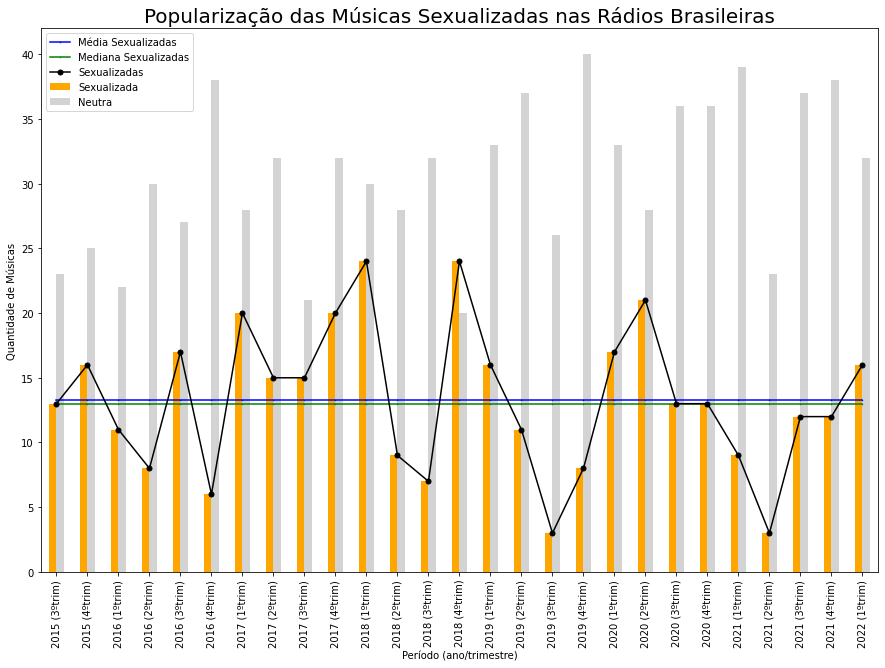

In [ ]:
# Representação gráfica nível Brasil da quantidade de músicas sexualizadas e neutras por período
# Agrupa os dados a nível do período
base_agg_sex = base_agg_reg.groupby(["trimestre"])["qtd_sexualizada"].sum().reset_index(name='qtd_sexualizada')
base_agg_neu = base_agg_reg.groupby(["trimestre"])["qtd_neutra"].sum().reset_index(name='qtd_neutra')
base_agg_periodo = pd.merge(base_agg_sex, base_agg_neu, on = "trimestre")
# Calcula a média e mediana da quantidade sexualizada de todo o conjunto de dados
base_agg_media = base_agg_periodo["qtd_sexualizada"].mean()
base_agg_mediana = base_agg_periodo["qtd_sexualizada"].median()
base_agg_periodo["media_sexualizada"] = base_agg_media
base_agg_periodo["mediana_sexualizada"] = base_agg_mediana
# Plota o gráfico da quantidade de músicas sexualizadas e neutras por período
base_agg_periodo.plot(x="trimestre", y=["qtd_sexualizada","qtd_neutra"], kind="bar", color = ["orange","lightgray"], label = ["Sexualizada","Neutra"])
base_agg_periodo["media_sexualizada"].plot(kind='line', marker='.', color='blue', ms=1, label = "Média Sexualizadas")
base_agg_periodo["mediana_sexualizada"].plot(kind='line', marker='.', color='green', ms=1, label = "Mediana Sexualizadas")
base_agg_periodo["qtd_sexualizada"].plot(kind='line', marker='.', color='black', ms=10, label = "Sexualizadas")
width = 0.15
plt.title("Popularização das Músicas Sexualizadas nas Rádios Brasileiras", fontsize = 20)
plt.xlabel("Período (ano/trimestre)")
plt.ylabel("Quantidade de Músicas")
plt.xticks(rotation='vertical')
plt.gcf().set_size_inches(15, 10) 
plt.legend()
plt.plot
plt.savefig("barras_agg_periodo.png")

In [ ]:
base_agg_reg.head()

,ano,trimestre,regiao,qtd_sexualizada,qtd_neutra,qtd_total
0,2015,2015 (3ºtrim),Centro Oeste,3,6,9.0
1,2015,2015 (3ºtrim),Nordeste,3,6,9.0
2,2015,2015 (3ºtrim),Norte,1,3,4.0
3,2015,2015 (3ºtrim),Sudeste,2,3,5.0
4,2015,2015 (3ºtrim),Sul,4,5,9.0


In [ ]:
# Calcula a média por ano a nível Brasil 
base_agg_ano_media = base_agg_reg.groupby(["trimestre"])["qtd_sexualizada"].agg('mean').reset_index(name='media_sexualizada')
# Calcula a mediana por ano a nível Brasil 
base_agg_ano_mediana = base_agg_reg.groupby(["trimestre"])["qtd_sexualizada"].agg('median').reset_index(name='mediana_sexualizada')
# Realiza merge dos datasets
base_agg_reg_merge1 = pd.merge(base_agg_reg, base_agg_ano_media, on = ["trimestre"])
base_agg_reg_merge2 = pd.merge(base_agg_reg_merge1, base_agg_ano_mediana, on = ["trimestre"])
base_agg_reg_final = base_agg_reg_merge2[["trimestre","regiao","qtd_sexualizada","qtd_neutra","media_sexualizada","mediana_sexualizada"]]
base_agg_reg_final.head()

,trimestre,regiao,qtd_sexualizada,qtd_neutra,media_sexualizada,mediana_sexualizada
0,2015 (3ºtrim),Centro Oeste,3,6,2.6,3.0
1,2015 (3ºtrim),Nordeste,3,6,2.6,3.0
2,2015 (3ºtrim),Norte,1,3,2.6,3.0
3,2015 (3ºtrim),Sudeste,2,3,2.6,3.0
4,2015 (3ºtrim),Sul,4,5,2.6,3.0


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

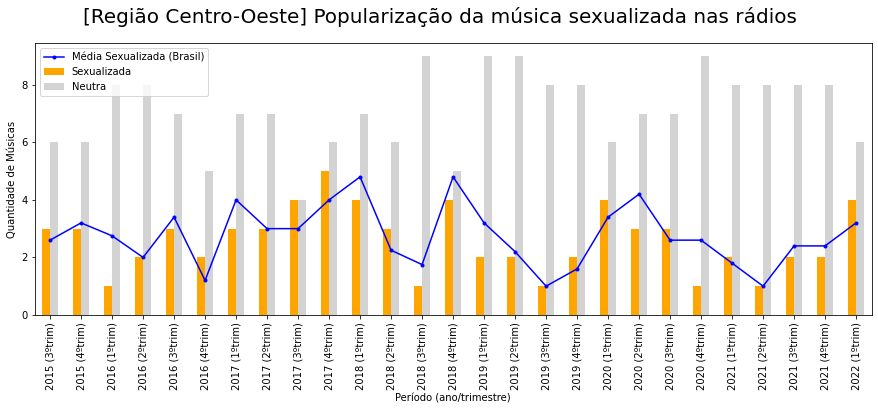

In [ ]:
# Plota o gráfico da quantidade de músicas sexualizadas da região Centro-Oeste
base_reg_centro = base_agg_reg_final.query('regiao=="Centro Oeste"')
# Calcula a média da quantidade de músicas sexualizada da região
base_reg_centro.plot(x="trimestre", y=["qtd_sexualizada","qtd_neutra"], kind="bar", color = ["orange","lightgray"], label = ["Sexualizada","Neutra"])
periodo = base_reg_centro["trimestre"].drop_duplicates()
x1 = np.arange(len(periodo))
plt.plot(x1, base_reg_centro["media_sexualizada"], marker='.', color='blue', label='Média Sexualizada (Brasil)')
plt.suptitle("[Região Centro-Oeste] Popularização da música sexualizada nas rádios", fontsize = 20)
width = 0.15
plt.xlabel("Período (ano/trimestre)")
plt.ylabel("Quantidade de Músicas")
plt.xticks(rotation='vertical')
plt.gcf().set_size_inches(15, 5) 
plt.legend(loc='upper left')
plt.subplot()
plt.savefig("barras_Centro-Oeste.png")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

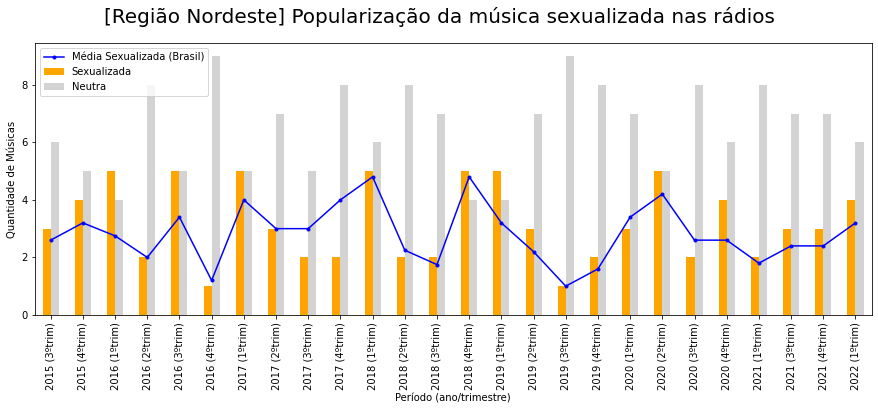

In [ ]:
# Plota o gráfico da quantidade de músicas sexualizadas da região Nordeste
base_reg_nordeste = base_agg_reg_final.query('regiao=="Nordeste"')
base_reg_nordeste.plot(x="trimestre", y=["qtd_sexualizada","qtd_neutra"], kind="bar", color = ["orange","lightgray"], label = ["Sexualizada","Neutra"])
periodo = base_reg_nordeste["trimestre"].drop_duplicates()
x1 = np.arange(len(periodo))
plt.plot(x1, base_reg_nordeste["media_sexualizada"], marker='.', color='blue', label='Média Sexualizada (Brasil)')
plt.suptitle("[Região Nordeste] Popularização da música sexualizada nas rádios", fontsize = 20)
width = 0.15
plt.xlabel("Período (ano/trimestre)")
plt.ylabel("Quantidade de Músicas")
plt.xticks(rotation='vertical')
plt.gcf().set_size_inches(15, 5) 
plt.legend(loc='upper left')
plt.subplot()
plt.savefig("barras_Nordeste.png")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

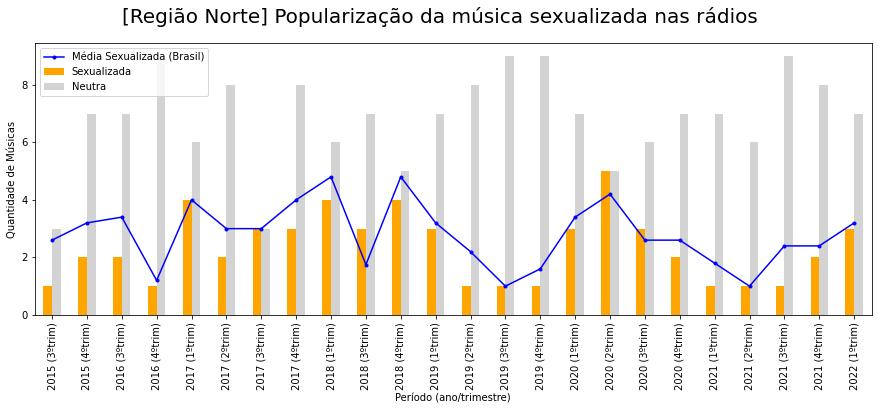

In [ ]:
# Plota o gráfico da quantidade de músicas sexualizadas da região Norte
base_reg_norte = base_agg_reg_final.query('regiao=="Norte"')
base_reg_norte.plot(x="trimestre", y=["qtd_sexualizada","qtd_neutra"], kind="bar", color = ["orange","lightgray"], label = ["Sexualizada","Neutra"])
periodo = base_reg_norte["trimestre"].drop_duplicates()
x1 = np.arange(len(periodo))
plt.plot(x1, base_reg_norte["media_sexualizada"], marker='.', color='blue', label='Média Sexualizada (Brasil)')
plt.suptitle("[Região Norte] Popularização da música sexualizada nas rádios", fontsize = 20)
width = 0.15
plt.xlabel("Período (ano/trimestre)")
plt.ylabel("Quantidade de Músicas")
plt.xticks(rotation='vertical')
plt.gcf().set_size_inches(15, 5) 
plt.legend(loc='upper left')
plt.subplot()
plt.savefig("barras_Norte.png")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

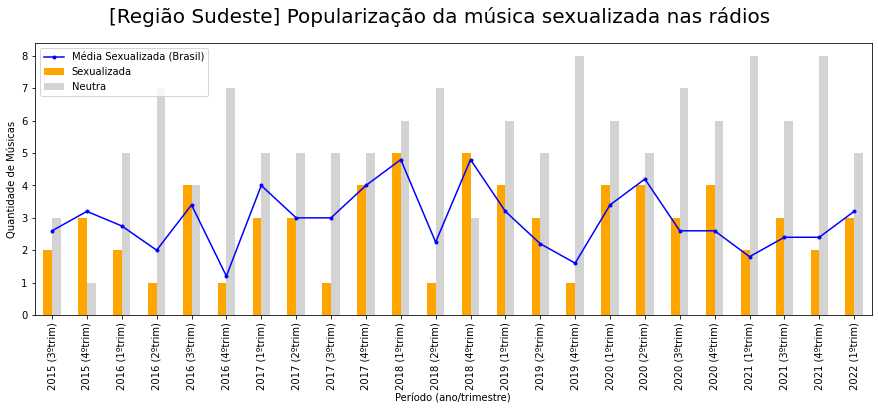

In [ ]:
# Plota o gráfico da quantidade de músicas sexualizadas da região Sudeste
base_reg_sudeste = base_agg_reg_final.query('regiao=="Sudeste"')
base_reg_sudeste.plot(x="trimestre", y=["qtd_sexualizada","qtd_neutra"], kind="bar", color = ["orange","lightgray"], label = ["Sexualizada","Neutra"])
periodo = base_reg_sudeste["trimestre"].drop_duplicates()
x1 = np.arange(len(periodo))
plt.plot(x1, base_reg_sudeste["media_sexualizada"], marker='.', color='blue', label='Média Sexualizada (Brasil)')
plt.suptitle("[Região Sudeste] Popularização da música sexualizada nas rádios", fontsize = 20)
width = 0.15
plt.xlabel("Período (ano/trimestre)")
plt.ylabel("Quantidade de Músicas")
plt.xticks(rotation='vertical')
plt.gcf().set_size_inches(15, 5) 
plt.legend(loc='upper left')
plt.subplot()
plt.savefig("barras_Sudeste.png")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

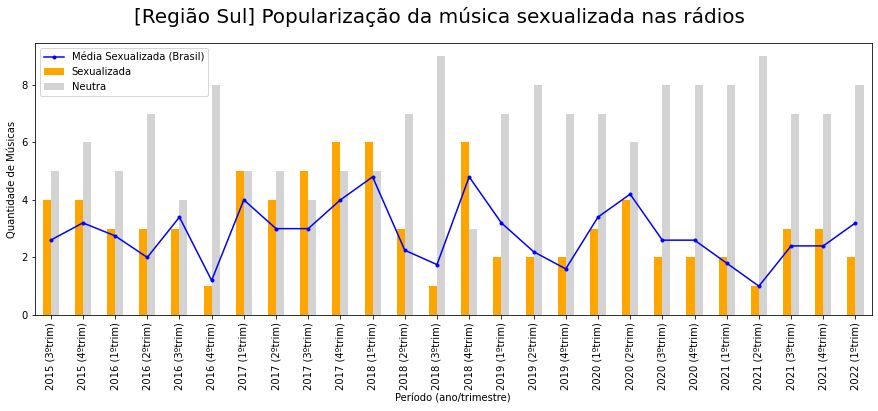

In [ ]:
# Plota o gráfico da quantidade de músicas sexualizadas da região Sul
base_reg_sul = base_agg_reg_final.query('regiao=="Sul"')
base_reg_sul.plot(x="trimestre", y=["qtd_sexualizada","qtd_neutra"], kind="bar", color = ["orange","lightgray"], label = ["Sexualizada","Neutra"])
periodo = base_reg_sul["trimestre"].drop_duplicates()
x1 = np.arange(len(periodo))
plt.plot(x1, base_reg_sul["media_sexualizada"], marker='.', color='blue', label='Média Sexualizada (Brasil)')
plt.suptitle("[Região Sul] Popularização da música sexualizada nas rádios", fontsize = 20)
width = 0.15
plt.xlabel("Período (ano/trimestre)")
plt.ylabel("Quantidade de Músicas")
plt.xticks(rotation='vertical')
plt.gcf().set_size_inches(15, 5) 
plt.legend(loc='upper left')
plt.subplot()
plt.savefig("barras_sul.png")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

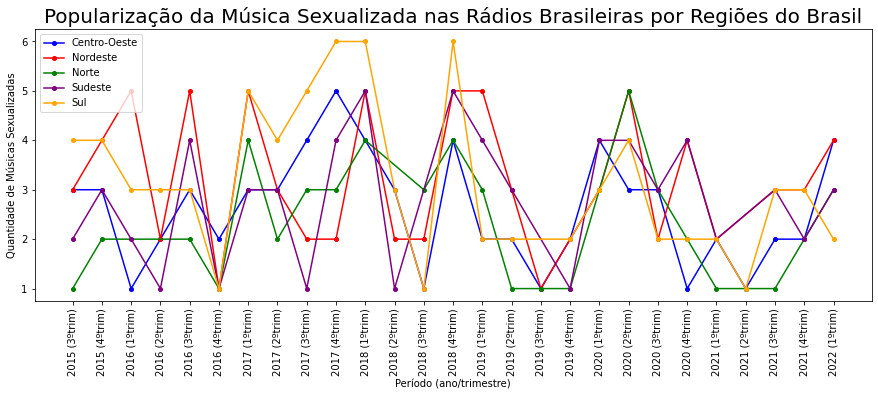

In [ ]:
# Gráfico comparação todas as regiões

plt.plot(base_reg_centro['trimestre'], base_reg_centro['qtd_sexualizada'], linestyle='-', color = 'blue', label = "Centro-Oeste", marker='o', markersize = 4)
plt.plot(base_reg_nordeste['trimestre'], base_reg_nordeste['qtd_sexualizada'], linestyle='-', color = 'red', label = "Nordeste", marker='o', markersize = 4)
plt.plot(base_reg_norte['trimestre'], base_reg_norte['qtd_sexualizada'], linestyle='-', color = 'green', label = "Norte", marker='o', markersize = 4)
plt.plot(base_reg_sudeste['trimestre'], base_reg_sudeste['qtd_sexualizada'], linestyle='-', color = 'purple', label = "Sudeste", marker='o', markersize = 4)
plt.plot(base_reg_sul['trimestre'], base_reg_sul['qtd_sexualizada'], linestyle='-', color = 'orange', label = "Sul", marker='o', markersize = 4)

plt.title("Popularização da Música Sexualizada nas Rádios Brasileiras por Regiões do Brasil", fontsize = 20)
width = 0.15
plt.xlabel("Período (ano/trimestre)")
plt.ylabel("Quantidade de Músicas Sexualizadas")
plt.xticks(rotation='vertical')
plt.gcf().set_size_inches(15, 5) 
plt.legend(loc='upper left')
plt.savefig("linhas_regioes.png")
plt.plot

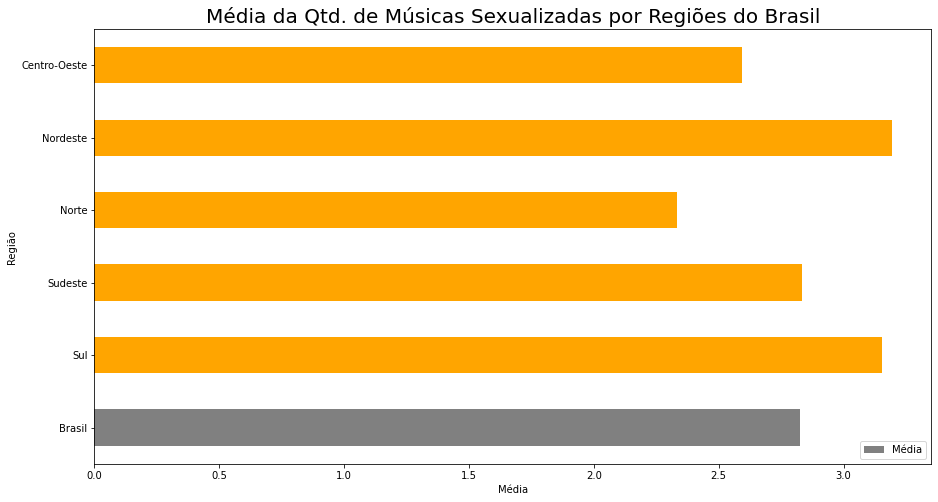

In [ ]:
# Gráfico média regiões
base_agg_media_centro = base_reg_centro["qtd_sexualizada"].mean()
base_agg_media_nordeste = base_reg_nordeste["qtd_sexualizada"].mean()
base_agg_media_norte = base_reg_norte["qtd_sexualizada"].mean()
base_agg_media_sudeste = base_reg_sudeste["qtd_sexualizada"].mean()
base_agg_media_sul = base_reg_sul["qtd_sexualizada"].mean()
base_media_geral = base_agg_reg_final["qtd_sexualizada"].mean()

media_regioes = [{"regiao":"Brasil","media_sexualizada":base_media_geral},
                {"regiao":"Sul","media_sexualizada":base_agg_media_sul},
                {"regiao":"Sudeste","media_sexualizada":base_agg_media_sudeste},
                {"regiao":"Norte","media_sexualizada":base_agg_media_norte},
                {"regiao":"Nordeste","media_sexualizada":base_agg_media_nordeste},
                {"regiao":"Centro-Oeste","media_sexualizada":base_agg_media_centro},
]
base_media_regioes = pd.DataFrame(data=media_regioes)

base_media_regioes.plot.barh(x='regiao', y='media_sexualizada', label = "Média", color=['gray', 'orange', 'orange', 'orange', 'orange', 'orange'])
plt.ylabel("Região")
plt.xlabel("Média")
plt.title("Média da Qtd. de Músicas Sexualizadas por Regiões do Brasil", fontsize = 20)
plt.gcf().set_size_inches(15, 8) 
plt.legend(loc=4)
plt.savefig("barras_regioes_media.png")
width = 0.15